# **Spaceship Titanic**
In this competition, we have data about passengers aboard the Spaceship Titanic. The data is divided into two files: train and test. In the "train" file, the column "Transported" shows whether the passenger was transported to another dimension or not.

First, I explore and clean the data, handling missing values and transforming categorical variables into numerical ones. Then, I create and engineer new features to enhance the predictive power of the model. Finally, I select the most important features and make predictions using a Random Forest classifier.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

In [11]:
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [12]:
train = pd.read_csv("~/Downloads/train.csv")
test = pd.read_csv("~/Downloads/test.csv")

In [13]:
train.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


# **Missing Data Imputation**
Many columns in the dataset have missing values, and handling these is crucial for building a reliable model. The strategy used here involves:

**Identifying Missing Values:**
First, I print the number of missing values in each important column, allowing me to see where data imputation is needed.

**Filling Missing Values:**
A dictionary is created that maps each column to a method of filling missing values:

For numerical columns like "Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", and "VRDeck", missing values are filled with either the mean or median, as appropriate.
For the "Cabin" column, missing values are replaced with the string "U", indicating an unknown cabin.
This approach ensures that the dataset is complete, reducing bias from missing data and allowing the machine learning model to use all available information effectively.

In [14]:
columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Cabin", "VIP"]

for col in columns:
    print(f"{col}: {train[col].isnull().sum()} missing values")

Age: 179 missing values
RoomService: 181 missing values
FoodCourt: 183 missing values
ShoppingMall: 208 missing values
Spa: 183 missing values
VRDeck: 188 missing values
Cabin: 199 missing values
VIP: 203 missing values


In [58]:
# Dictionary mapping columns to fillna method (mean, median, or a specific value)
fill_methods = {
    "Age": train["Age"].mean(),
    "RoomService": train["RoomService"].median(),
    "FoodCourt": train["FoodCourt"].median(),
    "ShoppingMall": train["ShoppingMall"].median(),
    "Spa": train["Spa"].median(),
    "VRDeck": train["VRDeck"].median(),
    "Cabin": "U"
}

# Loop through the dictionary and fill missing values
for col, value in fill_methods.items():
    train[col].fillna(value)

### **VIP**
The "VIP" status could be a useful feature to help determine passenger behavior or privileges that might affect survival rates. However, since some VIP statuses are missing, imputing these values is necessary. I randomly assign a portion of the missing values as False, indicating that these passengers are not VIPs, and set the remaining missing values as True, assuming some passengers with missing VIP data might still have been VIPs. While the method is somewhat arbitrary, it helps avoid the issue of missing data and allows the model to use the VIP feature for predictions.

In [16]:
train["VIP"].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [17]:
na_indices_vip = train[train["VIP"].isnull()].index

selected_indices_vip = np.random.choice(na_indices_vip, size=198, replace=False)

train.loc[selected_indices_vip, "VIP"] = False
train.loc[train['VIP'].isna(), 'VIP'] = True

### **HomePlanet**
The "HomePlanet" variable indicates the passenger's origin planet and is likely to influence survival, as different planets may have different resources or privileges. However, some entries in this column are missing. To address this, I impute the missing values by preserving the proportion of passengers from each planet (Earth, Mars, and Europa). I randomly assign a number of missing values to each planet based on the proportions observed in the existing data. This helps maintain the overall distribution of "HomePlanet" in the dataset while ensuring that no data is missing for this feature, allowing the model to make better predictions based on planetary origin.

In [18]:
train["HomePlanet"].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [19]:
# Preserving Proportion of Earth
na_indices = train[train["HomePlanet"].isnull()].index

# Proportion Size assisted by ChatGPT
selected_indices = np.random.choice(na_indices, size=108, replace=False)

train.loc[selected_indices, "HomePlanet"] = "Earth"

In [20]:
# Preserving Proportion of Mars
na_indices = train[train["HomePlanet"].isnull()].index

# Proportion Size assisted by ChatGPT
selected_indices = np.random.choice(na_indices, size=43, replace=False)

train.loc[selected_indices, "HomePlanet"] = "Mars"

In [21]:
# Preserving Proportion of Europa
na_indices = train[train["HomePlanet"].isnull()].index

# Proportion Size assisted by ChatGPT
selected_indices = np.random.choice(na_indices, size=50, replace=False)

train.loc[selected_indices, "HomePlanet"] = "Europa"

### **CryoSleep**
The "CryoSleep" variable indicates whether passengers were in cryogenic sleep during the voyage, which could affect their survival. However, some values in this column are missing. To handle this, I randomly assign 77 missing values to True (assuming these passengers were in cryogenic sleep) based on the existing data proportions. The remaining missing values are set to False, meaning those passengers were not in cryogenic sleep. This approach preserves the likely distribution of "CryoSleep" while ensuring that no data is missing, allowing the model to use this feature for predictions.

In [22]:
na_indices_cryo = train[train["CryoSleep"].isnull()].index

selected_indices_cryo = np.random.choice(na_indices_cryo, size=77, replace=False)

train.loc[selected_indices_cryo, "CryoSleep"] = True

train.loc[train['CryoSleep'].isna(), 'CryoSleep'] = False

### **Destination**
The "Destination" column indicates the passengers' intended destination, which may influence survival rates depending on the resources or environment of each location. However, some values in this column are missing. To address this:

**Proportionate Imputation:** I impute missing values by randomly assigning them based on the observed proportions of known destinations. Specifically:
- 126 missing values are assigned to "TRAPPIST-1e", which is the most common destination.
- 38 missing values are assigned to "55 Cancri e".
- 18 missing values are assigned to "PSO J318.5-22".
#
By preserving the original proportions of each destination in the dataset, this approach ensures that the model can leverage the "Destination" feature without being skewed by missing data.

In [23]:
train["Destination"].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [24]:
# Preserving Proportion of TRAPPIST-1e
na_indices = train[train["Destination"].isnull()].index

# Proportion Size assisted by ChatGPT
selected_indices = np.random.choice(na_indices, size=126, replace=False)

train.loc[selected_indices, "Destination"] = "TRAPPIST-1e"

In [25]:
# Preserving Proportion of 55 Cancri e
na_indices = train[train["Destination"].isnull()].index

# Proportion Size assisted by ChatGPT
selected_indices = np.random.choice(na_indices, size=38, replace=False)

train.loc[selected_indices, "Destination"] = "55 Cancri e"

In [26]:
# Preserving Proportion of PSO J318.5-22
na_indices = train[train["Destination"].isnull()].index

# Proportion Size assisted by ChatGPT
selected_indices = np.random.choice(na_indices, size=18, replace=False)

train.loc[selected_indices, "Destination"] = "PSO J318.5-22"

In [59]:
train["Name"].fillna("U")

0         Maham Ofracculy
1            Juanna Vines
2           Altark Susent
3            Solam Susent
4       Willy Santantines
              ...        
8688    Gravior Noxnuther
8689      Kurta Mondalley
8690         Fayey Connon
8691     Celeon Hontichre
8692     Propsh Hontichre
Name: Name, Length: 8693, dtype: object

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# **Exploratory Data Analysis**
In this section, I explore the dataset to gain insights and visualize the relationships between key variables and the target feature, "Transported" (whether passengers were transported to another dimension). Here's what each part of the code does:

**Descriptive Statistics:**
`train.describe(include="all")` provides summary statistics for all columns, including both numerical and categorical features. This helps understand the general characteristics of the data, such as mean, median, and frequency counts.

In [29]:
train.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8693,8693,8693,8693,8693.000000,8693,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693,8693
unique,8693,3,2,6561,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8474,2
top,0001_01,Earth,False,U,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,U,True
freq,1,4710,5579,199,6041,NaN,8489,NaN,NaN,NaN,NaN,NaN,200,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,220.009318,448.434027,169.572300,304.588865,298.261820,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.339054,NaN,660.519050,1595.790627,598.007164,1125.562559,1134.126417,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,41.000000,61.000000,22.000000,53.000000,40.000000,NaN,NaN


**Pairplot:**
`sns.pairplot(train, hue="Transported")` creates a pairwise scatter plot matrix, coloring data points by the "Transported" status. This helps visualize potential relationships between numerical features and the target variable.

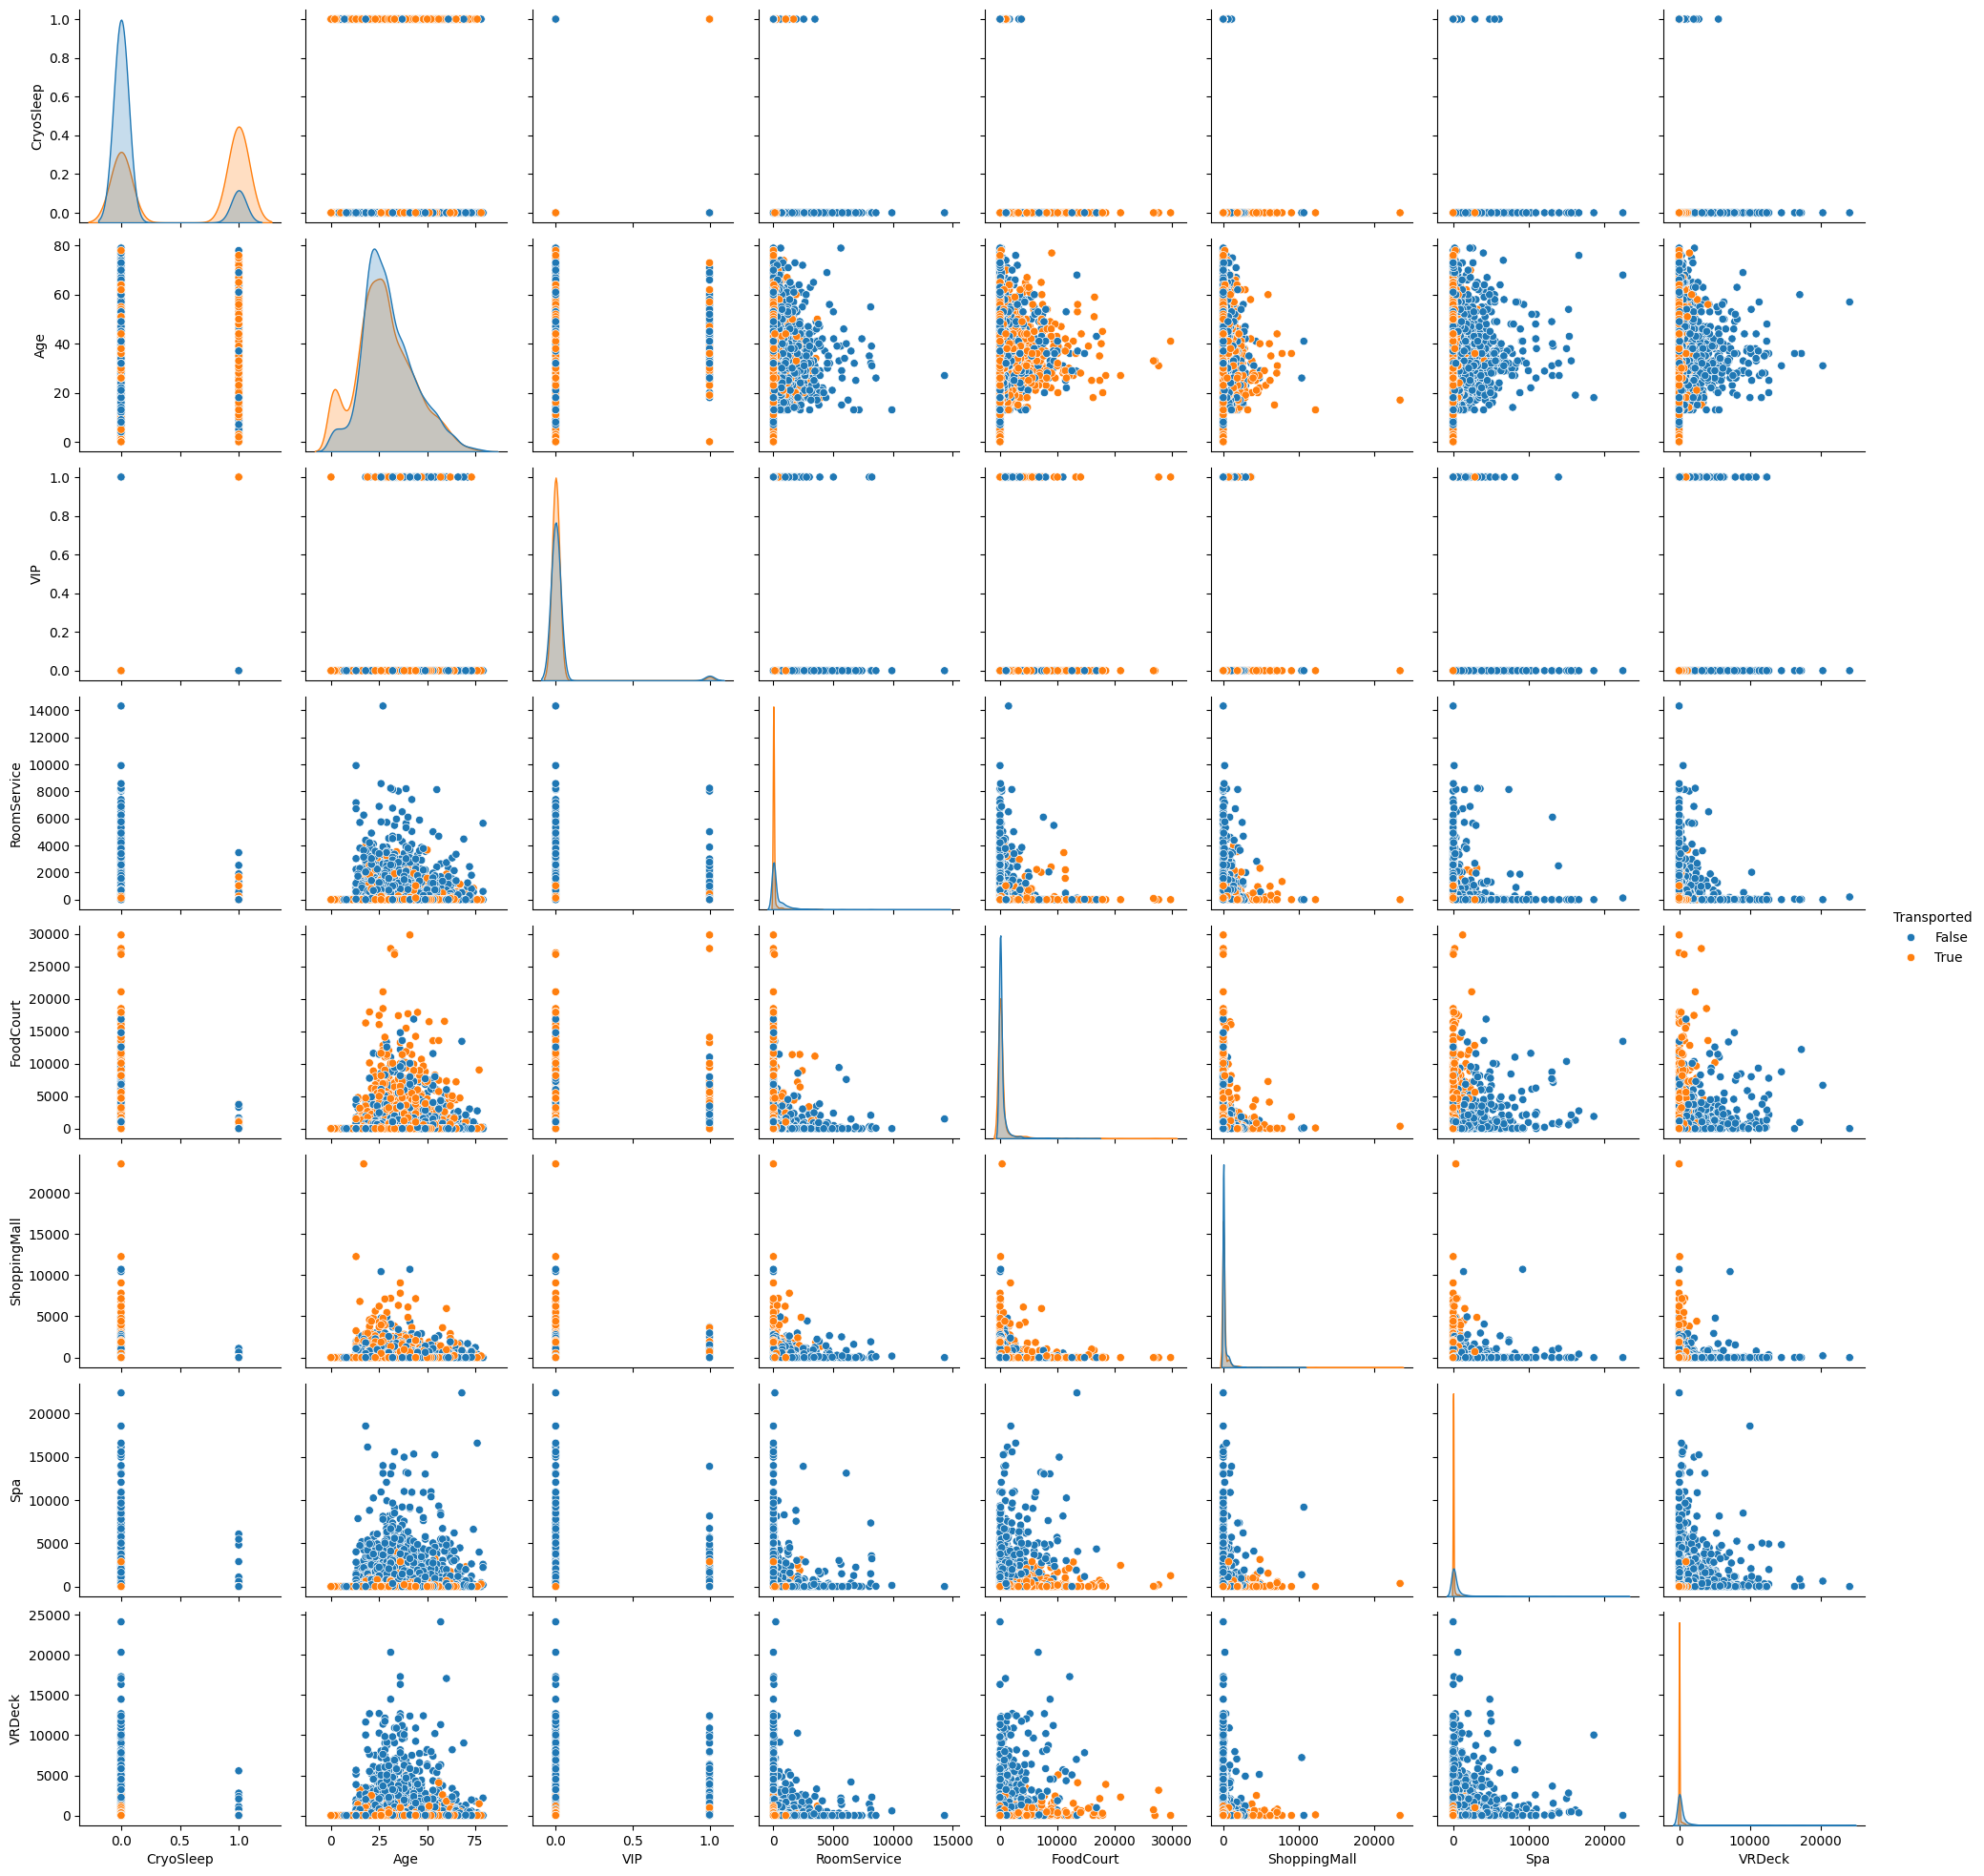

In [30]:
sns.pairplot(train, hue="Transported")

In [31]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Transport by HomePlanet:**
`planet_transport = train.groupby("HomePlanet")["Transported"].value_counts().unstack()` groups the data by "HomePlanet" and counts the number of passengers transported versus not transported for each planet. The bar plot `planet_transport.plot(kind="bar", stacked=False)` visually compares the transport status for passengers from each planet.



In [32]:
planet_transport = train.groupby("HomePlanet")["Transported"].value_counts().unstack()
planet_transport

Transported,False,True
HomePlanet,,
Earth,2704,2006
Europa,750,1431
Mars,861,941


<Axes: xlabel='HomePlanet'>

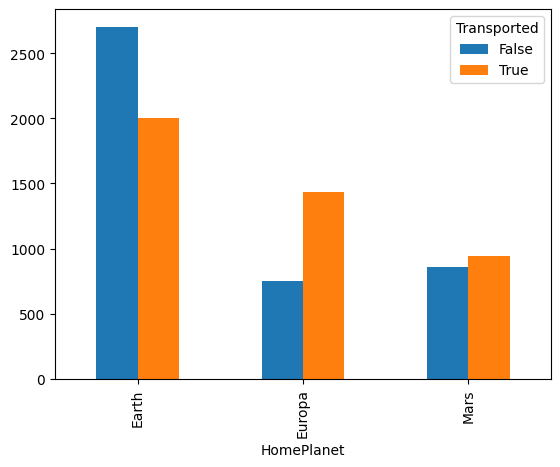

In [33]:
planet_transport.plot(kind="bar", stacked=False)

**Transport by CryoSleep:**
`sleep_transport = train.groupby("CryoSleep")["Transported"].value_counts().unstack()` performs a similar analysis, grouping passengers by whether they were in cryogenic sleep and plotting the results to see if there's a relationship between CryoSleep and the likelihood of being transported.

<Axes: xlabel='CryoSleep'>

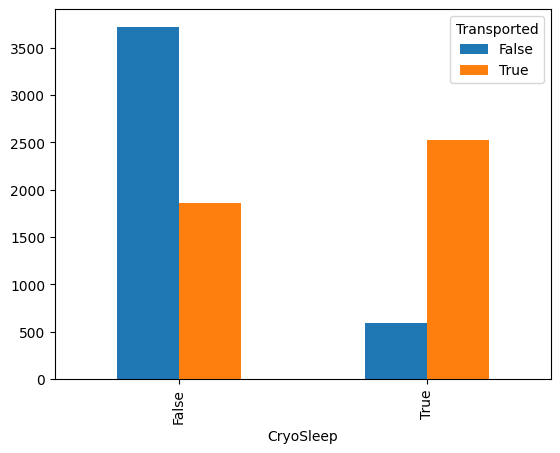

In [34]:
sleep_transport = train.groupby("CryoSleep")["Transported"].value_counts().unstack()
sleep_transport.plot(kind="bar", stacked=False)

**Transport by VIP:**
`vip_transport = train.groupby("VIP")["Transported"].value_counts().unstack()` groups passengers by their VIP status to compare transportation rates for VIP vs. non-VIP passengers. A bar plot is used to visualize this.

In [35]:
vip_transport = train.groupby("VIP")["Transported"].value_counts().unstack()
vip_transport

Transported,False,True
VIP,,
False,4191,4298
True,124,80


<Axes: xlabel='VIP'>

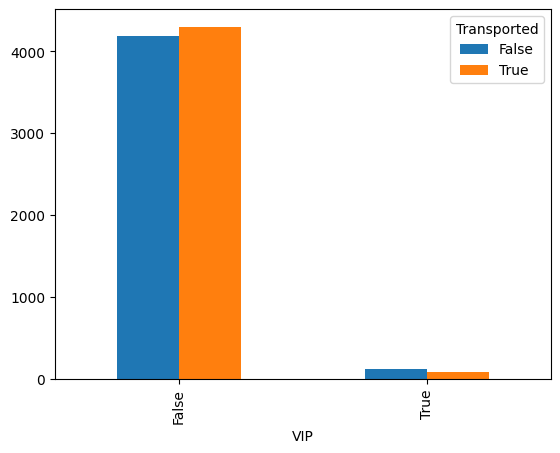

In [36]:
vip_transport.plot(kind="bar", stacked=False)

**Transport by Destination:**
`destination_transport = train.groupby("Destination")["Transported"].value_counts().unstack()` groups the data by passengers' destinations to analyze if the target destination impacts the likelihood of being transported.

In [37]:
destination_transport = train.groupby("Destination")["Transported"].value_counts().unstack()

<Axes: xlabel='Destination'>

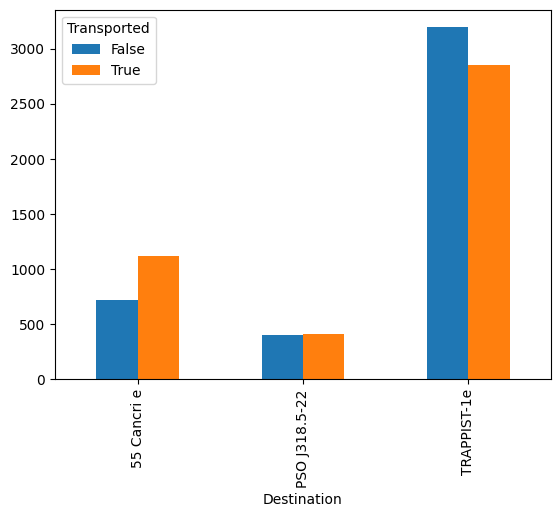

In [38]:
destination_transport.plot(kind="bar", stacked=False)

# **Random Forest Classifier**
In this section, you are building a machine learning model to predict whether passengers were "Transported" to another dimension using a Random Forest Classifier. Here's a detailed breakdown:

In [39]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [40]:
train["CryoSleep"].value_counts()

CryoSleep
False    5579
True     3114
Name: count, dtype: int64

In [41]:
train["Transported"].dtype

dtype('bool')

**Converting Categorical Variables to Numerical:**
Since machine learning models work with numerical data, you convert categorical columns in the test dataset into numerical representations:

- `HomePlanet`: Earth → 1, Mars → 2, others → 3
- `Destination`: TRAPPIST-1e → 1, 55 Cancri e → 2, others → 3
- `CryoSleep`: True → 1, False → 2
- `VIP`: True → 1, False → 2
#
This conversion is necessary for the model to interpret the categorical features.

In [42]:
### Cleaning Categorical Variables

train['HomePlanet'] = train["HomePlanet"].apply(lambda x: 1 if x in ["Earth"] else 2 if x in ["Mars"] else 3)

train['Destination'] = train["Destination"].apply(lambda x: 1 if x in ["TRAPPIST-1e"] else 2 if x in ["55 Cancri e"] else 3)

train["CryoSleep"] = train["CryoSleep"].apply(lambda x: 1 if x in ["True"] else 2)

train["VIP"] = train["VIP"].apply(lambda x: 1 if x == True else 2)

train["Transported"] = train["Transported"].apply(lambda x: 1 if x == True else 2)

In [43]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,3,2,B/0/P,1,39.0,2,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,2
1,0002_01,1,2,F/0/S,1,24.0,2,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,3,2,A/0/S,1,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,2
3,0003_02,3,2,A/0/S,1,33.0,2,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,2
4,0004_01,1,2,F/1/S,1,16.0,2,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [44]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [45]:
# Changing Categorical to Numerical Values

test['HomePlanet'] = test["HomePlanet"].apply(lambda x: 1 if x in ["Earth"] else 2 if x in ["Mars"] else 3)

test['Destination'] = test["Destination"].apply(lambda x: 1 if x in ["TRAPPIST-1e"] else 2 if x in ["55 Cancri e"] else 3)

test["CryoSleep"] = test["CryoSleep"].apply(lambda x: 1 if x in ["True"] else 2)

test["VIP"] = test["VIP"].apply(lambda x: 1 if x == True else 2)

**Random Forest Classifier Model:**
You initialize a **Random Forest Classifier** (`rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)`), which is an ensemble learning method based on decision trees. You fit the model to the training data using selected features such as age, home planet, and various service-related variables (`rf.fit(train[features], train["Transported"])`).

In [46]:
# With Billing Variables
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"])

# Cross Validation Score
print("RF cross val score", cross_val_score(rf, train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"], cv=5).mean())


RF cross val score 0.7836214614830289


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   int64  
 2   CryoSleep     4277 non-null   int64  
 3   Cabin         4177 non-null   object 
 4   Destination   4277 non-null   int64  
 5   Age           4186 non-null   float64
 6   VIP           4277 non-null   int64  
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage: 434.5+ KB


In [60]:
test["Age"].fillna(train.Age.mean())

0       27.00000
1       19.00000
2       31.00000
3       38.00000
4       20.00000
          ...   
4272    34.00000
4273    42.00000
4274    28.82793
4275    28.82793
4276    43.00000
Name: Age, Length: 4277, dtype: float64

In [61]:
test["RoomService"].fillna(train.RoomService.median())

test["FoodCourt"].fillna(train.FoodCourt.median())

test["ShoppingMall"].fillna(train.ShoppingMall.median())

test["Spa"].fillna(train.Spa.median())

test["VRDeck"].fillna(train.VRDeck.median())

0         0.0
1         0.0
2         0.0
3       585.0
4         0.0
        ...  
4272      0.0
4273    144.0
4274      0.0
4275    523.0
4276      0.0
Name: VRDeck, Length: 4277, dtype: float64

In [50]:
test["Transported"] = rf.predict(test[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])

# Convert back to Bool from int
test["Transported"] = test["Transported"].apply(lambda x: True if x == 1 else False)

test[["PassengerId", "Transported"]].to_csv("submission_rf.csv", index=False)

# **SVM Model**

In [51]:
svm = SVC()
svm.fit(train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"])

print("SVM cross val score",cross_val_score(svm, train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"], cv=5).mean())

SVM cross val score 0.7860378337351136


In [52]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,1,2,G/3/S,1,27.0,2,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,True
1,0018_01,1,2,F/4/S,1,19.0,2,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,False
2,0019_01,3,2,C/0/S,2,31.0,2,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,True
3,0021_01,3,2,C/1/S,1,38.0,2,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,True
4,0023_01,1,2,F/5/S,1,20.0,2,10.0,0.0,635.0,0.0,0.0,Brence Harperez,False


In [53]:
test["Transported"] = svm.predict(test[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])

test["Transported"] = test["Transported"].apply(lambda x: True if x == 1 else False)

test[["PassengerId", "Transported"]].to_csv('svm_submission.csv', index=False)

# **Logistic Regression Model**

In [54]:
lr = LogisticRegression()
lr.fit(train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"])

print("LR cross val score",cross_val_score(lr, train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"], cv=5).mean())

/Users/nathanielliganor/Documents/SummerProject/Study/venv2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nathanielliganor/Documents/SummerProject/Study/venv2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

LR cross val score 0.7822403653806831


/Users/nathanielliganor/Documents/SummerProject/Study/venv2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Voting Classifier**

In [55]:
vc = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('svm', svm)], voting='hard')

In [56]:
vc.fit(train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"])

print("VC cross val score",cross_val_score(vc, train[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]], train["Transported"], cv=5).mean())

/Users/nathanielliganor/Documents/SummerProject/Study/venv2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nathanielliganor/Documents/SummerProject/Study/venv2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

VC cross val score 0.790869188606867


In [57]:
test["Transported"] = vc.predict(test[["Age", "HomePlanet", "CryoSleep", "Destination", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])

test["Transported"] = test["Transported"].apply(lambda x: True if x == 1 else False)

test[["PassengerId", "Transported"]].to_csv('vc_submission.csv', index=False)